In [1]:
import math
import qiskit_qasm2
from qiskit_qasm2 import load, CustomClassical
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.linalg import expm
from numpy.linalg import norm, matrix_power
from functools import reduce
from itertools import product
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi
from matplotlib.ticker import MaxNLocator
import time

from icecream import ic

from os import listdir
from os.path import isfile, join

PAULIS = {'I': np.eye(2, dtype='complex'),
          'X': np.array([[0, 1], [1, 0]], dtype='complex'),
          'Y': np.array([[0, -1j], [1j, 0]]),
          'Z': np.diag(np.array([1, -1], dtype='complex'))}

dict_Walsh = {'00': 'I',
              '01': 'Z',
              '10': 'X',
              '11': 'Y'}

## for higher order the coefficients are of order 10^24/10^28
B_sign = {3: (np.array([-1,0,1]),2), # Accuracy is O(h^2)
          5: (np.array([1,-8,0,8,-1]),12), # Accuracy is O(h^4)
          7: (np.array([-1,9,-45,0,45,-9,1]),60), # Accuracy is O(h^6)
          9: (np.array([3,-32,168,-672,0,672,-168,32,-3]),840), # Accuracy is O(h^8)
          11: (np.array([-2,25,-150,600,-2100,0,2100,-600,150,-25,2]),2520)} # Accuracy is O(h^10)


def speed_multiple(b,c_map):
    """Multiply each column of a matrix by given constant."""
    for j, c in enumerate(c_map):
        b[:,j] *= c
    return b


def make_B(N, coefs, cbase):
    """ make matrix B s.t. L = -BB.T with correct zero boundary conditions.
    N - size of B.
    coefs - list of coefficients.
    cbase - divider.
    
    """
    B = np.zeros((N,N))
    l = len(coefs)//2
    diags = list(range(-l,l+1))
    for i,val in zip(diags,coefs):
        B += val*np.eye(N,k=i)

    ### Boundary connditions
    ## left side
    B[0,:] = np.zeros_like(B[0,:])
    B[:,0] = np.zeros_like(B[:,0])
    
    for i in range(l):
        coef_temp = coefs[-(i+1):]
        B[l-i,:len(coef_temp)] = B[l-i,:len(coef_temp)] - coef_temp
        # print(l-i, coef_temp)
    B[:,0] = B[:,0]*np.sqrt(2)

    ## right side
    B[-1,:] = np.zeros_like(B[-1,:])
    B[:,-1] = np.zeros_like(B[:,-1])
    for i in range(l):
        coef_temp = coefs[:(i+1)]
        B[-(l-i)-1,-len(coef_temp):] = B[-(l-i)-1,-len(coef_temp):] - coef_temp
        # print(-(l-i)-1, coef_temp)
    B[:,-1] = B[:,-1]*np.sqrt(2)
    
    # return B
    return B/cbase


def get_pauli_from_xz(x,z,n):
    """ Return Pauli string and a coefficient given
    x - integer number 
    z - integer number 
    n - lenght of binary representation
    """
    a = bin(x & z).count("1")
    p_str = ''.join([dict_Walsh[i+j] for i,j in zip(f'{x:0{n}b}',f'{z:0{n}b}')])
    b = p_str.count('Z')
    return 1j**(a+3*b), p_str

def get_wwH(x, z, H):
    N = H.shape[0]
    a = bin(x & z).count("1")
    beta = sum([(-1)**(bin(z & p).count("1"))*H[p,x ^ p] for p in range(N)]) # bottleneck! list contain a lot of zeros!
    return 1j**(a)*beta/N


t_trotter_comm_group = None
weights_from_func_W = None
def W(x, z, dummy):
    """
    Returns angle for rz
    x - x-stirng or group-id
    z - z-stirng
    dummy - cbase (normalization for finite difference scheme)
    example of rz: rz(w(10,10,60))
    """
    # global c_weight
    x = int(x)
    z = int(z)
    wwH = get_wwH(x, z, H)
    weights_from_func_W.append(wwH)
    rz_angle = 2*t_trotter_comm_group*wwH
    return rz_angle.real

customs = [
    CustomClassical("w", 3, W),
]


def get_trotter_map_one_step(dict_sets: dict, t: float, order: int):
    """ Compute the trotter map, i.e.
    the result is list of tuples (key, weight) where key is one of the keys from dict_sets
    and weight is resulted weight which arises due to product formula.
    These pairs are repeated the exact number of times as they should in product formula.
    
    dict_sets - dictionary with pairs key : commuting group.
    t - time in resulted exp(tH).
    order = p = 2k - order of the product formula (see formulas (10,11) in Theory of Trotter Error with Commutator Scaling (https://doi.org/10.1103/PhysRevX.11.011020))
    
    """
    if order < 0:
        raise ValueError("Formula order must be 1 or greater")
    if order % 2 == 1 and order != 1:
        raise ValueError("Formula order p = 2k must even number or 1")
    
    if order == 1:
        pairs_list = [(set_id, t)
                      for set_id in dict_sets.keys()]
        return pairs_list[::-1]
    elif order == 2:
        pairs_list = [(set_id, t * 0.5)
                      for set_id in dict_sets.keys()]
        pairs_list[-1] = (pairs_list[-1][0], 2 * pairs_list[-1][1])
        return pairs_list + pairs_list[-2::-1]
    else:
        u_p = 1 / (4 - 4**(1 / (order - 1)))
        tf_1 = get_trotter_map_one_step(dict_sets, u_p*t, order - 2)
        tf_2 = get_trotter_map_one_step(dict_sets, (1-4*u_p)*t, order - 2)
        
        assert tf_2[0][0] == tf_1[-1][0]
        assert tf_2[-1][0] == tf_1[0][0]
        assert tf_1[-1][0] == tf_1[0][0]
        
        tf_2 = [(tf_2[0][0], tf_2[0][1]+tf_1[-1][1])] + tf_2[1:-1] + [(tf_2[-1][0], tf_2[-1][1]+tf_1[0][1])]
        tf_1 = tf_1[:-1] + [(tf_1[-1][0], tf_1[-1][1]*2)] + tf_1[1:]
        
        return tf_1[:-1] + tf_2 + tf_1[1:]
    
    
    
def get_matr_one_step(dict_sets, COEF, p):
    
    number_2q_gates = 0
    number_1q_gates = 0
    two_qubit_gates = set(['cx', 'cz'])
    one_qubit_gates = set(['h', 'rz'])
    
    exp_trotter = np.eye(len(H))
    product_formula_map = get_trotter_map_one_step(dict_sets, COEF, p)
    for k, t_trotter in product_formula_map:
        
        def W(x, z, dummy):
            """
            Returns angle for rz
            x - x-stirng or group-id
            z - z-stirng
            dummy - cbase (normalization for finite difference scheme), it also contatin sign
            example of rz: rz(w(10,10,60))
            """
            x = int(x)
            z = int(z)
            wwH = get_wwH(x, z, H)
            s = np.sign(dummy)
            rz_angle = s*2*t_trotter*wwH
            return rz_angle.real

        customs = [
            CustomClassical("w", 3, W),
        ]

        filename = dict_sets[k]
        circuit = load(filename, custom_classical=customs).reverse_bits()
        dict_gates = circuit.count_ops()
        number_2q_gates +=  sum([v for k,v in dict_gates.items() if k in two_qubit_gates])
        number_1q_gates +=  sum([v for k,v in dict_gates.items() if k in one_qubit_gates])
        matrix = qi.Operator(circuit).data
        exp_trotter = exp_trotter@matrix
        
    total_gates_one_step = number_2q_gates+number_1q_gates
    return exp_trotter, total_gates_one_step



def get_B_H_expmH(acc_order, nq, t, dx):
    """
    Parameters:
    acc_order - accuracy order for spce derivative,
    nq - number of qubits used for matix B, i.e. total number minus 1.
    t - time from expm(-iHt/dx),
    dx - space step from expm(-iHt/dx).
    
    Returns:
    B - matrix B, i.e. matrix for finite deffiernce scheme,
    H - Hamiltonian composed of matrix B and B transposed (since all entries are real),
    expm_H - expm(-iHt/dx) computed directly.
    """
    n_points = der_acc_order + 1
    coef_B,cb_B = B_sign[n_points]
    B = make_B(2**(nq),coef_B,cb_B)
    H = np.block([[np.zeros_like(B), B],[B.T, np.zeros_like(B)]])
    expm_H = expm(-1j*H*t/dx)
    return B, H, expm_H


def get_dict_sets(mypath, acc_order, nq):
    """
    Parameters:
    mypath - path to folder with QASM files,
    acc_order - accuracy order for spce derivative,
    nq - number of qubits used for matix B, i.e. total number minus 1.

    Returns:
    dict_sets - with paths to qasm files.
    """
    file_names = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f)) and '-{}_{}_'.format(acc_order,nq+1) in f]
    dict_sets = dict(zip(range(len(file_names)),file_names))
    return dict_sets


def bin_search_for_trotter_power(r_left, r_right, set_error, t, dx, dict_sets, p, exp_H, verbose):
    """
    Parameters:
    r_left - initial left border for number of trotter steps,
    r_right - initial right border for number of trotter steps,
    set_error - error to look for,
    t - time from expm(-iHt/dx),
    dx - space step from expm(-iHt/dx),
    dict_sets - dictionary with paths to qasm files,
    p - order of Trotter formula,
    exp_H - expm(-iHt/dx) computed directly,
    verbose = False - work silently, True - display progress.
    
    
    Returns:
    r_right - Number of trotter steps,
    t_gates - Number of gates for one step,
    trotter_error_fin - Actual error || epxm_trotter - expm(H) ||.
    """
#     if verbose: ic.enable()
    time_start = time.time()
#     ic('Looking for exact Trotter power from: {} - {}'.format(r_left, r_right))
    flag_print = True
    while r_left<=r_right:
        if flag_print: time_iter_start = time.time()
        r = (r_left + r_right)//2
        COEF = t/r/dx
        exp_trotter, total_gates_one_step = get_matr_one_step(dict_sets, COEF, p)
        exp_trotter = matrix_power(exp_trotter, r)
        trotter_error = norm(exp_H - exp_trotter, ord=2)

        if r_left == r_right:
            r_right = r
            trotter_error_fin = trotter_error
            t_gates = total_gates_one_step
            break

        if trotter_error > set_error:
            r_left = r+1
        else:
            r_right = r
            trotter_error_fin = trotter_error
            t_gates = total_gates_one_step
        if flag_print: time_iter_end = time.time()
        if flag_print: print('\tTime for one iteration of binary search: {:.3f} s'.format(time_iter_end - time_iter_start))
        flag_print = False
    time_end = time.time()
    print('\tTime to compute: {:.3f} s'.format(time_end - time_iter_end))
#     ic('time to compute: {:.3f} s'.format(time.time() - time_start))
#     ic('Number of trotter steps = {}'.format(r_right))
#     ic('Number of gates for one step: {}'.format(t_gates))
#     ic('Actual error = {}'.format(trotter_error_fin))
    
#     if verbose: ic.disable()
    return r_right, t_gates, trotter_error_fin

def bin_search_for_trotter_power(r_left, r_right, set_error, t, dx, dict_sets,
                                 p, exp_H, schr_init, exact_solution, verbose):
    """
    Parameters:
    r_left - initial left border for number of trotter steps,
    r_right - initial right border for number of trotter steps,
    set_error - error to look for,
    t - time from expm(-iHt/dx),
    dx - space step from expm(-iHt/dx),
    dict_sets - dictionary with paths to qasm files,
    p - order of Trotter formula,
    exp_H - expm(-iHt/dx) computed directly,
    schr_init - inital state for schrodinger equation,
    exact_solution - standing wave solution,
    verbose = False - work silently, True - display progress.
    
    
    Returns:
    r_right - Number of trotter steps,
    t_gates - Number of gates for one step,
    trotter_error_fin - Actual error || epxm_trotter - expm(H) ||.
    """
#     if verbose: ic.enable()
    time_start = time.time()
#     ic('Looking for exact Trotter power from: {} - {}'.format(r_left, r_right))
    flag_print = True
    while r_left<=r_right:
        if flag_print: time_iter_start = time.time()
        r = (r_left + r_right)//2
        COEF = t/r/dx
        exp_trotter, total_gates_one_step = get_matr_one_step(dict_sets, COEF, p)
        exp_trotter = matrix_power(exp_trotter, r)
        trotter_error = norm(exp_H - exp_trotter, ord=2)
        num_solution = exp_trotter@schr_init
        num_solution = num_solution[:len(num_solution)//2].real
        st_wave_error = norm(num_solution - exact_solution, ord=2)
        
        num_solution = exp_H@schr_init
        num_solution = num_solution[:len(num_solution)//2].real
        st_wave_error_best = norm(num_solution - exact_solution, ord=2)

        if r_left == r_right:
            r_right = r
            trotter_error_fin = trotter_error
            st_wave_error_fin = st_wave_error
            t_gates = total_gates_one_step
            break

        if st_wave_error > set_error:
            r_left = r+1
        else:
            r_right = r
            trotter_error_fin = trotter_error
            st_wave_error_fin = st_wave_error
            t_gates = total_gates_one_step
        if flag_print: time_iter_end = time.time()
        if flag_print: print('\tTime for one iteration of binary search: {:.3f} s'.format(time_iter_end - time_iter_start))
        flag_print = False
    time_end = time.time()
    print('\tTime to compute: {:.3f} s'.format(time_end - time_iter_end))
#     ic('time to compute: {:.3f} s'.format(time.time() - time_start))
#     ic('Number of trotter steps = {}'.format(r_right))
#     ic('Number of gates for one step: {}'.format(t_gates))
#     ic('Actual error = {}'.format(trotter_error_fin))
    
#     if verbose: ic.disable()
    return r_right, t_gates, trotter_error_fin, st_wave_error_fin, st_wave_error_best

## Number of qubits vs Accuracy

In [123]:
"""Parameters"""
l = 1
t = 1
p = 2 # Trotter formula order
set_error = 10**(-5) # Set error between exact solution and numerical
path_to_qasm_files = 'QASM_files-orders-2-10_qubits-4-10'

A = 1
c_max = 1

print('Constant speed profile')
print('Parameters: t = {} || lenght = {}'.format(t, l))
print('order of Trotter formula: {}'.format(p))
print('Set error: {:.2E}'.format(set_error))


der_acc_order_list = [2,4,6,8,10] # space derivative accuracy order
NQ_list = [4,5,6,7,8,9,10] # Total number of qubits


trotter_error_list_nq = []
st_wave_error_list_nq = []
r_list_nq = []
one_step_gate_count_list_nq = []
    
for NQ in NQ_list:
    print('----------------- Total number of qubits = {} -----------------'.format(NQ))
    nq = NQ - 1
    x_real = np.linspace(0,l,2**(nq))
    dx = x_real[1]-x_real[0]
    r_left = 1
    r_right = 10**6
    """ Initial conditions (classic) """
    psi_init = A*np.sin(x_real*np.pi/l)
    dpsi_dt_init = np.zeros_like(x_real)

    psi_final = A*np.sin(x_real*np.pi/l)*np.cos(c_max*t*np.pi/l) # exact solution

    """ Initial conditions (Schrodinger) """
    psi_0_sch = np.concatenate((psi_init, dpsi_dt_init))
#     psi_0_sch /= np.sqrt(np.sum(np.abs(psi_0_sch**2))) # normalization

    trotter_error_list = []
    st_wave_error_list = []
    r_list = []
    one_step_gate_count_list = []
    
    for der_acc_order in der_acc_order_list:
        print('\t----------------- Space derivative accuracy order = {} -----------------'.format(der_acc_order))
        _, H, expm_H = get_B_H_expmH(der_acc_order, nq, t, dx)
        dict_sets = get_dict_sets(path_to_qasm_files, der_acc_order, nq)
        r, num_gates_one_step, trotter_error, st_wave_error, st_wave_error_best = bin_search_for_trotter_power(r_left, r_right, set_error,
                                                                            t, dx, dict_sets, p, expm_H,
                                                                            psi_0_sch, psi_final, verbose=True)
        print('\tNumber of trotter steps: {}'.format(r))
        print('\tNumber of gates for 1 step: {}'.format(num_gates_one_step))
        print('\tTotal number of gates: {}'.format(r*num_gates_one_step))
        print('\tTrotter error: {:.2E}'.format(trotter_error))
        print('\tSolution error: {:.2E}'.format(st_wave_error))
        print('\tSolution error (best): {:.2E}'.format(st_wave_error_best))
        
        r_list.append(r)
        one_step_gate_count_list.append(num_gates_one_step)
        trotter_error_list.append(trotter_error)
        st_wave_error_list.append(st_wave_error)
        
    trotter_error_list_nq.append(trotter_error_list)
    st_wave_error_list_nq.append(st_wave_error_list)
    r_list_nq.append(r_list)
    one_step_gate_count_list_nq.append(one_step_gate_count_list)
    
    

trotter_error_list_nq = np.array(trotter_error_list_nq)
st_wave_error_list_nq = np.array(st_wave_error_list_nq)
r_list_nq = np.array(r_list_nq)
one_step_gate_count_list_nq = np.array(one_step_gate_count_list_nq)

Constant speed profile
Parameters: t = 1 || lenght = 1
order of Trotter formula: 2
Set error: 1.00E-05
----------------- Total number of qubits = 4 -----------------
	----------------- Space derivative accuracy order = 2 -----------------
	Time for one iteration of binary search: 0.019 s
	Time to compute: 0.297 s
	Number of trotter steps: 1000000
	Number of gates for 1 step: 166
	Total number of gates: 166000000
	Trotter error: 4.03E-09
	Solution error: 1.02E-02
	Solution error (best): 1.02E-02
	----------------- Space derivative accuracy order = 4 -----------------
	Time for one iteration of binary search: 0.036 s
	Time to compute: 0.553 s
	Number of trotter steps: 1000000
	Number of gates for 1 step: 338
	Total number of gates: 338000000
	Trotter error: 8.10E-09
	Solution error: 1.61E-05
	Solution error (best): 1.61E-05
	----------------- Space derivative accuracy order = 6 -----------------
	Time for one iteration of binary search: 0.044 s
	Time to compute: 0.715 s
	Number of trotte

	Time for one iteration of binary search: 8.204 s
	Time to compute: 163.853 s
	Number of trotter steps: 38584
	Number of gates for 1 step: 12462
	Total number of gates: 480833808
	Trotter error: 1.26E-04
	Solution error: 1.00E-05
	Solution error (best): 2.67E-13
----------------- Total number of qubits = 9 -----------------
	----------------- Space derivative accuracy order = 2 -----------------
	Time for one iteration of binary search: 17.100 s
	Time to compute: 341.667 s
	Number of trotter steps: 9645
	Number of gates for 1 step: 5652
	Total number of gates: 54513540
	Trotter error: 2.85E-03
	Solution error: 1.00E-05
	Solution error (best): 3.57E-08
	----------------- Space derivative accuracy order = 4 -----------------
	Time for one iteration of binary search: 34.621 s
	Time to compute: 695.844 s
	Number of trotter steps: 40845
	Number of gates for 1 step: 11598
	Total number of gates: 473720310
	Trotter error: 4.03E-04
	Solution error: 1.00E-05
	Solution error (best): 1.06E-13
	--

KeyboardInterrupt: 

In [125]:
file_name = "data_Accuracy_order-{}_to_{}_NQ-{}_to_{}_Trotter_order-{}".format(der_acc_order_list[0],
                                                                                   der_acc_order_list[-1],
                                                                                   NQ_list[0],
                                                                                   NQ_list[len(trotter_error_list_nq)-1],
                                                                                   p)

data_dict = {'trotter_error_list_nq':trotter_error_list_nq,
             'st_wave_error_list_nq':st_wave_error_list_nq,
             'r_list_nq':r_list_nq,
             'one_step_gate_count_list_nq':one_step_gate_count_list_nq,
             'der_acc_order_list':der_acc_order_list,
             'NQ_list':NQ_list[:len(trotter_error_list_nq)],
             'set_error':set_error,
             'l':l,
             't':t,
             'trotter_order':p,
            }

np.save(file_name, data_dict, allow_pickle=True)

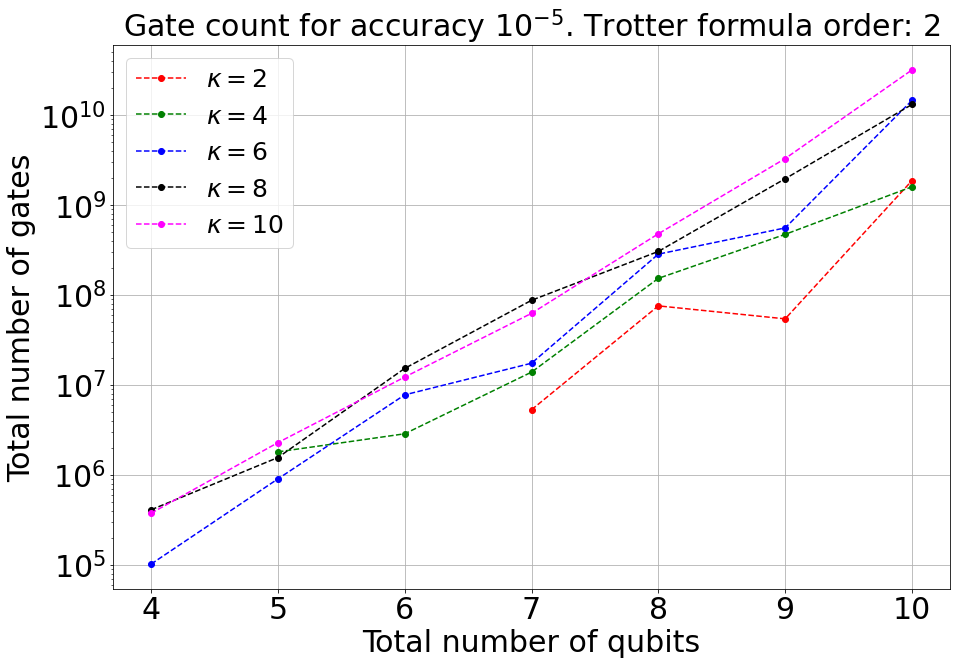

In [127]:
plt.figure(figsize = (15,10))
colour_list = ['r','g','b','black','magenta']

assert len(colour_list) == len(der_acc_order_list)

for params in zip(der_acc_order_list, colour_list,
                  trotter_error_list_nq.T, st_wave_error_list_nq.T,
                  r_list_nq.T, one_step_gate_count_list_nq.T):
    der_acc_order, c, trotter_error_list, st_wave_error_list, r_list, one_step_gate_count_list = params
    
    assertion_list = st_wave_error_list<=set_error
    
    NQ_list_corrected = []
    total_gate_count_list_corrected = []
    for NQ, r, one_step_gate_count, assertion in zip(NQ_list, r_list, one_step_gate_count_list, assertion_list):
        if assertion:
            NQ_list_corrected.append(NQ)
            total_gate_count_list_corrected.append(r*one_step_gate_count)
    
    plt.plot(NQ_list_corrected, total_gate_count_list_corrected, marker='o', c=c,
             linestyle='dashed',label='$\kappa = {}$'.format(der_acc_order))
    
    
    
plt.yscale('log')
# plt.xscale('log')
plt.grid(alpha = 1)
plt.legend(fontsize = 25)
plt.title('Gate count for accuracy $10^{%d}$. Trotter formula order: %d'%(int(np.log10(set_error)),p), fontsize = 30)
plt.xlabel('Total number of qubits', fontsize = 30 )
plt.ylabel('Total number of gates', fontsize = 30 )

plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)


figFilename = "total_gate_count_Set_error-10{}_".format(int(np.log10(set_error)))
figFilename += "Accuracy_order-{}_to_{}_NQ-{}_to_{}_Trotter_order-{}.pdf".format(der_acc_order_list[0],
                                                                                 der_acc_order_list[-1],
                                                                                 NQ_list[0],NQ_list[-1],p)
plt.savefig(figFilename, format="pdf", bbox_inches="tight")

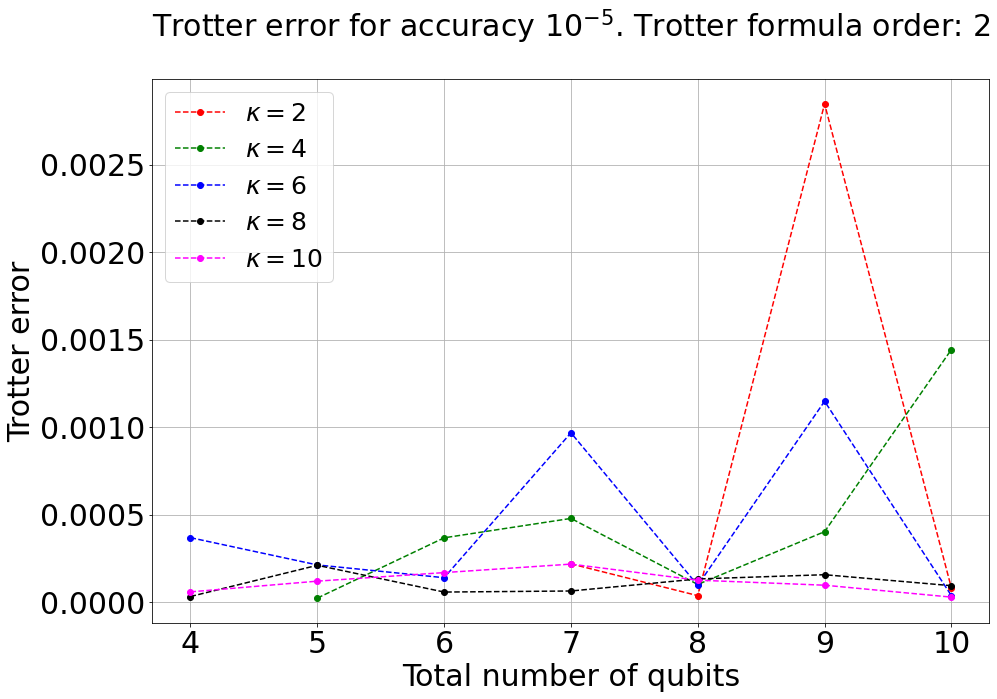

In [128]:
plt.figure(figsize = (15,10))

colour_list = ['r','g','b','black','magenta']

assert len(colour_list) == len(der_acc_order_list)

for params in zip(der_acc_order_list, colour_list,
                  trotter_error_list_nq.T, st_wave_error_list_nq.T,
                  r_list_nq.T, one_step_gate_count_list_nq.T):
    der_acc_order, c, trotter_error_list, st_wave_error_list, r_list, one_step_gate_count_list = params
    
    assertion_list = st_wave_error_list<=set_error
    
    NQ_list_corrected = []
#     total_gate_count_list_corrected = []
    trotter_error_list_corrected = []
    for NQ, trotter_error, assertion in zip(NQ_list, trotter_error_list, assertion_list):
        if assertion:
            NQ_list_corrected.append(NQ)
            trotter_error_list_corrected.append(trotter_error)
    
    plt.plot(NQ_list_corrected, trotter_error_list_corrected, marker='o', c=c,
             linestyle='dashed',label='$\kappa = {}$'.format(der_acc_order))
    
    
    
# plt.yscale('log')
# plt.xscale('log')
plt.grid(alpha = 1)
plt.legend(fontsize = 25)
plt.title('Trotter error for accuracy $10^{%d}$. Trotter formula order: %d\n'%(int(np.log10(set_error)),p), fontsize = 30)
plt.xlabel('Total number of qubits', fontsize = 30 )
plt.ylabel('Trotter error', fontsize = 30 )

plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
ax = plt.gca()
ax.yaxis.offsetText.set_fontsize(25)
# ax.yaxis.set_offset_position('right')

# plt.axes()
figFilename = "trotter_error_Set_error-10{}_".format(int(np.log10(set_error)))
figFilename += "Accuracy_order-{}_to_{}_NQ-{}_to_{}_Trotter_order-{}.pdf".format(der_acc_order_list[0],
                                                                                 der_acc_order_list[-1],
                                                                                 NQ_list[0],NQ_list[-1],p)
plt.savefig(figFilename, format="pdf", bbox_inches="tight")

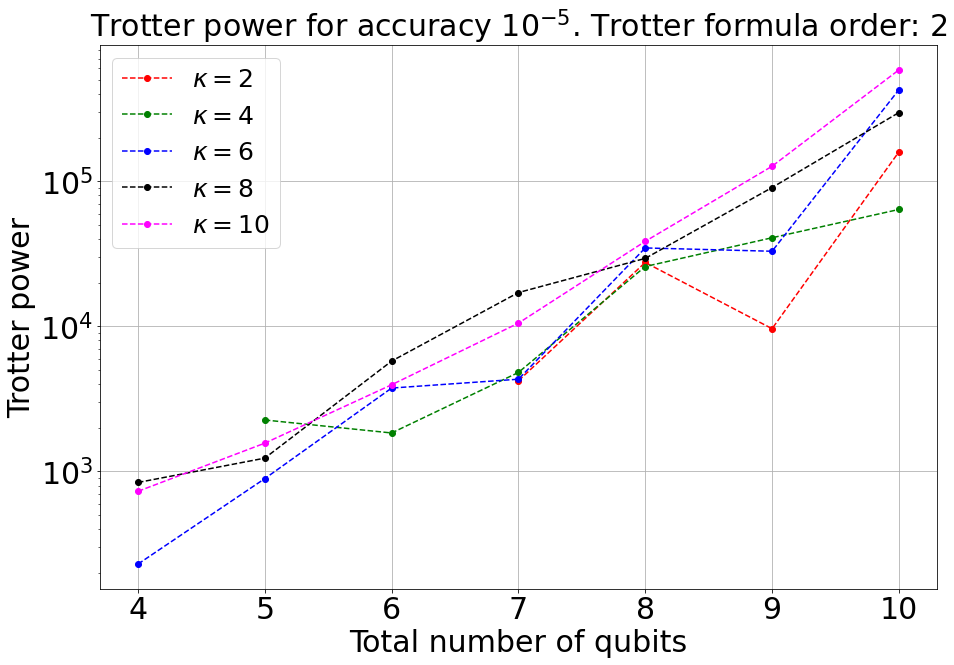

In [129]:
plt.figure(figsize = (15,10))

colour_list = ['r','g','b','black','magenta']

assert len(colour_list) == len(der_acc_order_list)

for params in zip(der_acc_order_list, colour_list,
                  trotter_error_list_nq.T, st_wave_error_list_nq.T,
                  r_list_nq.T, one_step_gate_count_list_nq.T):
    der_acc_order, c, trotter_error_list, st_wave_error_list, r_list, one_step_gate_count_list = params
    
    assertion_list = st_wave_error_list<=set_error  
            
    NQ_list_corrected = []
    r_list_corrected = []
    for NQ, r, assertion in zip(NQ_list, r_list, assertion_list):
        if assertion:
            NQ_list_corrected.append(NQ)
            r_list_corrected.append(r)
    
    plt.plot(NQ_list_corrected, r_list_corrected, marker='o', c=c,
             linestyle='dashed',label='$\kappa = {}$'.format(der_acc_order))
    
    
    
plt.yscale('log')
# plt.xscale('log')
plt.grid(alpha = 1)
plt.legend(fontsize = 25)
plt.title('Trotter power for accuracy $10^{%d}$. Trotter formula order: %d'%(int(np.log10(set_error)),p), fontsize = 30)
plt.xlabel('Total number of qubits', fontsize = 30 )
plt.ylabel('Trotter power', fontsize = 30 )

plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)


figFilename = "trotter_power_Set_error-10{}_".format(int(np.log10(set_error)))
figFilename += "Accuracy_order-{}_to_{}_NQ-{}_to_{}_Trotter_order-{}.pdf".format(der_acc_order_list[0],
                                                                                 der_acc_order_list[-1],
                                                                                 NQ_list[0],NQ_list[-1],p)
plt.savefig(figFilename, format="pdf", bbox_inches="tight")